<a href="https://colab.research.google.com/github/Floki1337/thesis/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Installing needed dependencies

In [0]:
!pip3 install -q mlxtend
!pip3 install -q kaggle

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.environ['KAGGLE_USERNAME']=""
os.environ['KAGGLE_KEY']=""

###Importing the dataset

In [0]:
!kaggle datasets download -d gaborfodor/keras-pretrained-models

 98% 921M/943M [00:12<00:00, 63.3MB/s]
100% 943M/943M [00:12<00:00, 79.1MB/s]


In [0]:
#!unzip -q -o chest-xray-pneumonia.zip
!#unzip -q -o chest_xray.zip
!unzip -q -o keras-pretrained-models.zip

###Importing the dependecies

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import cv2 
import glob
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.models import load_model
from keras.layers import Average
from keras import applications
from keras.models import Model
from keras import optimizers
import seaborn as sns
from keras.metrics import binary_accuracy
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Dropout,GlobalAveragePooling2D
from keras import backend as K

#the data is separated in folders according to the class, the path is abnormally long because we store our data in Google Drive.


import os
#Change in accordance with your own paths
train_dir_normal = "../content/drive/My Drive/models/research/object_detection/images/train/Target_0_PNGs/*.png"
train_dir_not_normal = "../content/drive/My Drive/models/research/object_detection/images/train/Target_0NN_PNGs/*.png"
train_dir_pneumonia = "../content/drive/My Drive/models/research/object_detection/images/train/Target_1_PNGs/*.png"
val_dir_normal = "../content/drive/My Drive/models/research/object_detection/images/train/VAL_norm/*.png"
val_dir_pneumonia = "../content/drive/My Drive/models/research/object_detection/images/train/VAL_pneu/*.png"
test_dir_normal = "../content/drive/My Drive/models/research/object_detection/images/train/new NORMAL/*.png"
test_dir_pneumonia = "../content/drive/My Drive/models/research/object_detection/images/train/new PNEUMONIA/*.png"
%matplotlib inline

Using TensorFlow backend.


###Defining helper functions

In [0]:

def shuffle_in_unison(a,b):
	assert len(a) == len(b)
	p = np.random.permutation(len(a))
	return a[p], b[p]

In [0]:
def convert_to_one_hot(vec, num):
    Y = np.eye(num)[vec.reshape(-1)].T
    return Y

In [0]:
def load_data():
    """A function to load the whole dataset and the labels"""
    train_data = []
    val_data = []
    test_data = []

    train_labels = [] 
    val_labels = []
    test_labels = []



    # groupping the file names into arrays and then we're gonna read each img and put it in the above array 
    train_files_normal = glob.glob(train_dir_normal)
    train_files_not_normal = glob.glob(train_dir_not_normal)
    train_files_pneumonia = glob.glob(train_dir_pneumonia)
    val_files_normal = glob.glob(val_dir_normal) 
    val_files_pneumonia = glob.glob(val_dir_pneumonia)

    test_files_normal = glob.glob(test_dir_normal) 
    test_files_pneumonia = glob.glob(test_dir_pneumonia)

    
    #importiing the files into the array of labels

    for num, file in enumerate(train_files_normal + train_files_pneumonia):
        img = cv2.imread(file, 1) 
        img = cv2.resize(img, (200,200))#resizing an image to 200x200
        train_data.append(img)
        if(num+1 <= 4394):# if it is less than 4394, it is normal else not
            train_labels.append(0)
        else:
            train_labels.append(1)
    
    for num, file in enumerate(val_files_normal + val_files_pneumonia):
        img = cv2.imread(file, 1)
        img = cv2.resize(img, (200,200)) #resizing an image to 200x200
        val_data.append(img)
        if(num+1 <= 250): # if it is less than 250, it is normal else not
            val_labels.append(0) 
        else:
            val_labels.append(1)
    
    for num, file in enumerate(test_files_normal + test_files_pneumonia):
        img = cv2.imread(file, 1)
        img = cv2.resize(img, (200,200)) #resizing an image to 200x200
        test_data.append(img)
        if(num+1 <= 250): # if it is less than 250, it is normal else not
            test_labels.append(0)
        else:
            test_labels.append(1)
    
    #converting files to numpy arrays
    X_train = np.array(train_data)
    X_val  = np.array(val_data)
    X_test = np.array(test_data)
    
    Y_train = np.array(train_labels)
    Y_val = np.array(val_labels)
    Y_test = np.array(test_labels) 
    
    X_train, Y_train = shuffle_in_unison(X_train,Y_train)
    X_val, Y_val = shuffle_in_unison(X_val,Y_val)
    X_test, Y_test = shuffle_in_unison(X_test,Y_test)
  
    return X_train, Y_train, X_val, Y_val, X_test, Y_test 


In [0]:
import os
directory = 'drive/My Drive/models/research/object_detection/images/train/Target_1_PNGs'

print('there are ' + str(len(os.listdir(directory))) + ' files in the directory')

there are 5149 files in the directory


###Load the data

In [0]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = load_data()

In [0]:
# Further preparing the data 
X_train = X_train/ 255 
X_val = X_val/ 255 
X_test = X_test/ 255

Y_train = convert_to_one_hot(Y_train, 2).T
Y_val = convert_to_one_hot(Y_val, 2).T
Y_test = convert_to_one_hot(Y_test, 2).T

print("shape of X_train : " + str(X_train.shape))
print("shape of X_val : " + str(X_val.shape))
print("shape of X_test : " + str(X_test.shape))
print("shape of Y_train : " + str(Y_train.shape))
print("shape of Y_val : " + str(Y_val.shape))
print("shape of Y_test : " + str(Y_test.shape))

shape of X_train : (9543, 200, 200, 3)
shape of X_val : (500, 200, 200, 3)
shape of X_test : (500, 200, 200, 3)
shape of Y_train : (9543, 2)
shape of Y_val : (500, 2)
shape of Y_test : (500, 2)


y = [1. 0.]


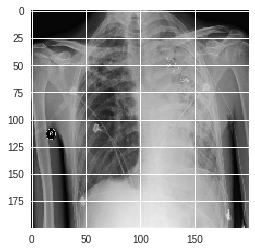

In [0]:
plt.imshow(X_test[150])
print("y = " + str(np.squeeze(Y_train[150])))

###Model definition

In [0]:
#use the model pre-trained on imagenet weights
base_model = applications.VGG16(include_top = False, weights = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
#base_model = applications.vgg19.VGG19(include_top=False, weights='imagenet')
#base_model = applications.ResNet50(include_top = False, weights = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [0]:
#use gradient descent technique(ADAM optimizer)
sgd = optimizers.Adam(lr = 1e-4)

In [0]:
# now we build a function to train the model and add a bottleneck model to our pre-trained one 
def Train_model(X_train, Y_train, X_test, Y_test, optimizer, base_model, batch_size = 64, num_epochs = 10):
    
    X = base_model.output
    X = Dropout(0.5)(X)
    X = GlobalAveragePooling2D()(X)
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dense(2, activation='sigmoid')(X)
    model = Model(inputs = base_model.input, outputs = X)
    
    for layer in base_model.layers:
        layer.trainable = False 
        
    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    model.fit(X_train,Y_train,
              batch_size = batch_size,
              epochs = num_epochs,
              validation_data = (X_test,Y_test))
    
    return model

In [0]:
model = Train_model(X_train, Y_train, X_test, Y_test, sgd, base_model, batch_size = 64, num_epochs = 10)
#save the model
model.save('VGG16.h5')
#model.save('VGG19.h5')
#model.save('inception.h5')

Train on 9543 samples, validate on 500 samples
Epoch 1/10
9543/9543 [==============================] - 85s 9ms/step - loss: 0.5239 - acc: 0.7400 - val_loss: 0.6186 - val_acc: 0.7240
Epoch 2/10
9543/9543 [==============================] - 81s 8ms/step - loss: 0.3813 - acc: 0.8437 - val_loss: 0.5559 - val_acc: 0.7760
Epoch 3/10
9543/9543 [==============================] - 81s 9ms/step - loss: 0.3536 - acc: 0.8568 - val_loss: 0.5407 - val_acc: 0.7820
Epoch 4/10
9543/9543 [==============================] - 81s 9ms/step - loss: 0.3336 - acc: 0.8639 - val_loss: 0.4345 - val_acc: 0.8040
Epoch 5/10
9543/9543 [==============================] - 81s 9ms/step - loss: 0.3198 - acc: 0.8688 - val_loss: 0.4555 - val_acc: 0.8120
Epoch 6/10
9543/9543 [==============================] - 81s 9ms/step - loss: 0.3163 - acc: 0.8661 - val_loss: 0.4343 - val_acc: 0.8140
Epoch 7/10
9543/9543 [==============================] - 81s 9ms/step - loss: 0.3076 - acc: 0.8705 - val_loss: 0.4183 - val_acc: 0.8100
Epoch 8/

In [0]:
#Creating a confusion matrix for one model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(Y_test, axis = 1) 
conf_mat = confusion_matrix(y_true, y_pred) 

conf_mat

array([[149, 101],
       [ 20, 230]])

###Ensembling

In [0]:
#loading pre-trained models

vgg19 = load_model('VGG19.h5')

vgg16 = load_model('VGG16.h5')

inception = load_model('inception.h5')

In [0]:
#creating an ensemble of three models
output = vgg16.predict(X_test) + vgg19.predict(X_test) + inception.predict(X_test)
ensemble_pred = np.exp(output/3)-1

In [0]:
#confusion matrix for the ensemble
ensemble_pred = np.argmax(ensemble_pred, axis = 1)
y_true = np.argmax(Y_test, axis = 1) 
ens_conf_mat = confusion_matrix(y_true, ensemble_pred)
ens_conf_mat

array([[200,  50],
       [ 40, 210]])

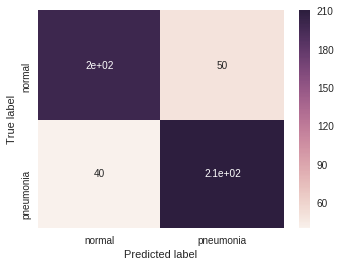

In [0]:
cm_df = pd.DataFrame(ens_conf_mat,
                     index = ['normal','pneumonia'], 
                     columns = ['normal','pneumonia'])


plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
